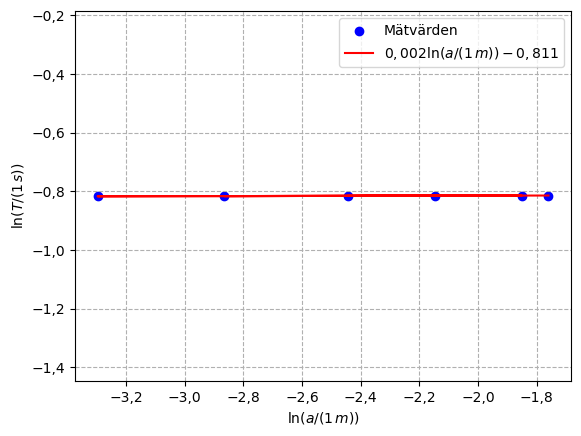

{'T': -1, 'l': 0, 'x': 0, 'y': 0, 'ρ/ε': 0, 'a': np.float64(0.0), 'd': 0}


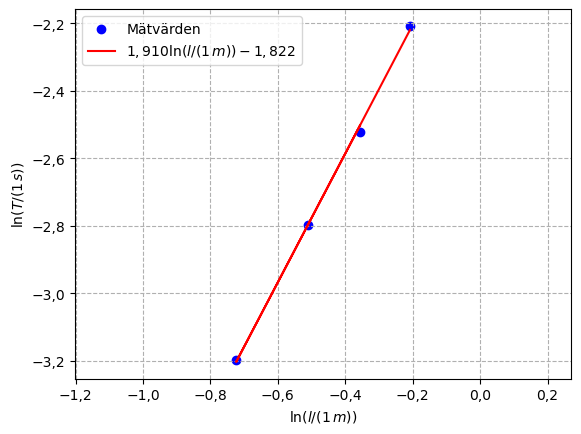

{'T': -1, 'l': np.float64(2.0), 'x': 0, 'y': 0, 'ρ/ε': 0, 'a': np.float64(0.0), 'd': 0}


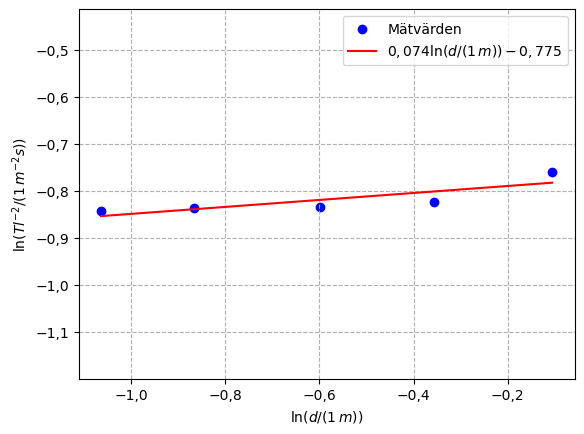

{'T': -1, 'l': np.float64(2.0), 'x': 0, 'y': 0, 'ρ/ε': 0, 'a': np.float64(0.0), 'd': np.float64(0.0)}


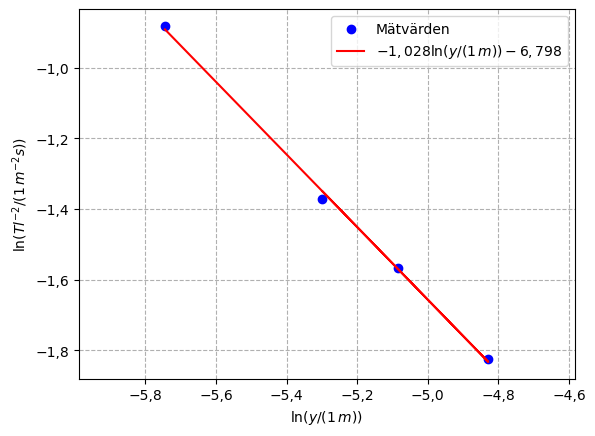

{'T': -1, 'l': np.float64(2.0), 'x': 0, 'y': np.float64(-1.0), 'ρ/ε': 0, 'a': np.float64(0.0), 'd': np.float64(0.0)}


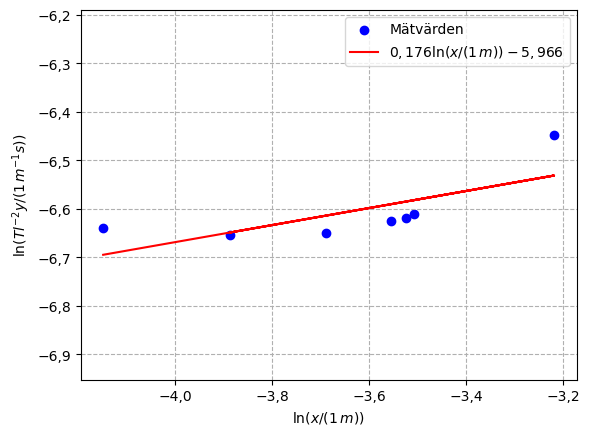

{'T': -1, 'l': np.float64(2.0), 'x': np.float64(0.0), 'y': np.float64(-1.0), 'ρ/ε': 0, 'a': np.float64(0.0), 'd': np.float64(0.0)}


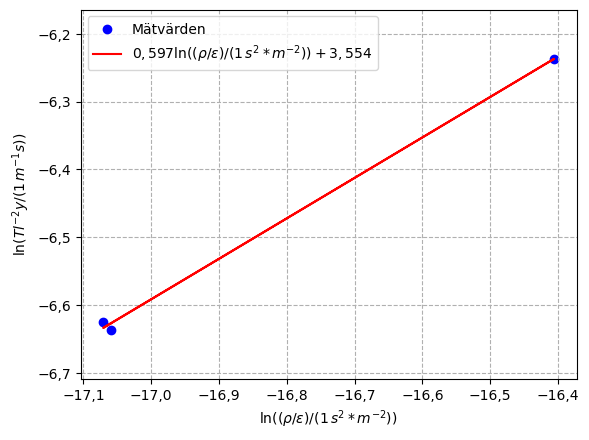

{'T': -1, 'l': np.float64(2.0), 'x': np.float64(0.0), 'y': np.float64(-1.0), 'ρ/ε': np.float64(0.5), 'a': np.float64(0.0), 'd': np.float64(0.0)}


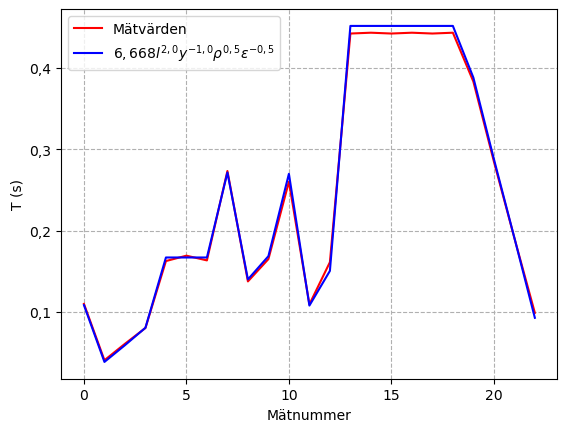

Felfortplantingsresultat: 0.6258064423722578


In [1]:
import numpy as np
import locale
import json

#Open and read the JSON file
file = open('config.json', 'r', encoding="UTF8")
data = json.load(file)
# Set to Swedish locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "se_SE")
import matplotlib.pyplot as plt
plt.rcdefaults()
# Tell matplotlib to use the locale we set above
plt.rcParams['axes.formatter.use_locale'] = True
filename = data['datafilename']
varden = np.loadtxt(filename, dtype = 'str',delimiter = '\t')
for i in range(len(varden)):
    for j in range(len(varden[i])):
        varden[i][j] = varden[i][j].replace(',','.')
rvariables = data['rvariables']
uvariables = data['uvariables']
runits = data['runits']
uunits = data['uunits']
errormargins = data['errormargins']
unitpows = data['unitpows'] 
rcollecteddata = {}
determined = {}
rexp = {}
for variable in rvariables: 
    rcollecteddata[variable] = []
    rexp[variable] = 0
ucollecteddata = {}
uexp = data['determinedexponents']
for variable in uvariables: 
    ucollecteddata[variable] = []
    if uexp[variable] != 0: 
        determined[variable] = True
    else: 
        uexp[variable] = 0
        determined[variable] = False
C = 0.
def collectdata(dicti,num): #convert measurement data from a txt-file into a dictionary
    for i in range(len(varden)):
        rcollecteddata[dicti].append(float(varden[i][num]))
def compositevariables():
    for unit in uunits:
        divideis = False
        for symbol in unit:
            if symbol == '/':
                divideis = True
                divide = unit.split('/')
                for i in range(len(rcollecteddata[divide[0]])):
                    ucollecteddata[unit].append(rcollecteddata[divide[0]][i]/rcollecteddata[divide[1]][i])
        if not divideis:
            for i in range(len(rcollecteddata[unit])):
                    ucollecteddata[unit].append(rcollecteddata[unit][i])
def choosemeasures(var,det,collecteddata,variables,errormargin): #choose series of measurement with the objective of creating a broad series with respect to (un)determined variables
    occurencedata = countoccurences(collecteddata,variables,var,det,errormargin)
    prevmax = 1
    maxnum = 0
    for i in range(len(occurencedata['occur'])):
        if occurencedata['occur'][i] > prevmax:
            maxnum = i
            prevmax = occurencedata['occur'][i]
    return(occurencedata['vals'][maxnum])
def countoccurences(collecteddata,variables,var,det,errormargin):
    vals = []
    occur= []
    for i in range(len(collecteddata[var])):
        val = {}
        earlierseries = True
        for variable in variables:
            val[variable] = collecteddata[variable][i]
        if len(vals) == 0: earlierseries = False
        elif val[var] != 0:
            for j in range(len(vals)):
                earlierseries = True
                for variable in variables:
                    if not '/' in variable and var != variable:
                        if not determined[variable] and np.abs(vals[j][variable] - val[variable]) > errormargin[variable]: 
                            earlierseries = False
                            equalmeasure = j
                    elif var != variable:
                        if not determined[variable] and np.abs(vals[j][variable] - val[variable]) > 0: 
                            earlierseries = False
                  
                if earlierseries:
                    newmeas = True
                    for k in range(len(vals)):
                        if not '/' in var and np.abs(val[var] - vals[k][var]) <= errormargin[var]: newmeas = False 
                        elif np.abs(val[var] - vals[k][var]) == 0: newmeas = False
                        for variable in variables:
                            if val[variable] == 0 and not determined[variable]: newmeas = False
                    if newmeas: 
                        occur[j] += 1
                    break
        if not earlierseries and val[var] != 0: 
            vals.append(val)
            occur.append(1)
    return({'vals':vals,'occur':occur})
def linearizeandplot(var,det,collecteddata,variables,exp,units,errormargin): #linearize the given series of measurements using the logarithmic methodology
    det[var] = True
    vals = choosemeasures(var,det,collecteddata,variables,errormargin)
    for si in unitpows:
        unitpows[si] = 0
    plottedfunc= {'func':[], var:[]}
    for i in range(len(collecteddata[var])):
        usevar = True
        for variable in variables:
            if not det[variable] and '/' not in variable: 
                if np.abs(collecteddata[variable][i] - vals[variable]) > errormargin[variable]: usevar = False
        if usevar:
            yval = collecteddata[variables[0]][i]
            for variable in variables:
                if exp[variable] != 0 and variable != variables[0]:
                    yval /= (collecteddata[variable][i]**exp[variable])
            yval = np.log(yval)
            xval = np.log(collecteddata[var][i])
            plottedfunc['func'].append(yval)
            plottedfunc[var].append(xval)
            uplottedfunc = {'func':[], var:[]}
            occur = []
        for i in range(len(plottedfunc[var])):
            useries = True
            if uplottedfunc[var] != 0:
                for j in range(len(uplottedfunc[var])):
                    if plottedfunc[var][i] == uplottedfunc[var][j]:
                        occur[j] += 1.
                        uplottedfunc['func'][j] = (uplottedfunc['func'][j]*(occur[j] -1) + plottedfunc['func'][i])/occur[j]
                        useries = False
                        break
            if useries:
                uplottedfunc['func'].append(plottedfunc['func'][i])
                uplottedfunc[var].append(plottedfunc[var][i])
                occur.append(1.)
    coeffs = np.polyfit(uplottedfunc[var], uplottedfunc['func'], 1)
    ylabel = r'$\ln('
    for variable in variables:
        if exp[variable] != 0:
            ylabel += variable
            if exp[variable] != -1: ylabel += '^{' + str(int(-exp[variable])) + '}'
            unitpows[units[variable]] += exp[variable]
    fracexist = False
    for si in unitpows:
        if unitpows[si] != 0: 
            if not fracexist:
                ylabel += r'/(1\,'
                fracexist = True
            ylabel += si
            if unitpows[si] != -1: ylabel += '^{' + str(int(-unitpows[si])) + '}'
    if fracexist: ylabel += ')'
    ylabel += ')$'
    size = np.max([np.max(uplottedfunc[var])-np.min(uplottedfunc[var]),np.max(uplottedfunc['func']) - np.min(uplottedfunc['func'])])
    plt.scatter(uplottedfunc[var],uplottedfunc['func'], label = 'Mätvärden', color = 'blue')
    plt.axis('equal')
    yvals = []
    for i in range(len(plottedfunc[var])):
        yvals.append(plottedfunc[var][i]*coeffs[0] + coeffs[1])
    if '/' in var: xlabel =r'$\ln(('+var+r')/(1\,'+units[var]+'))$'
    else: xlabel =r'$\ln('+var+r'/(1\,'+units[var]+'))$'
    const = f'{coeffs[1]:.3f}'.replace('.',',')
    sign = ''
    if coeffs[1] > 0: sign += '+'
    elif coeffs[1] == 0: const = ''
    funclabel = '$' + f'{coeffs[0]:.3f}'.replace('.',',') + xlabel.strip('$') + sign + const + '$'
    plt.plot(plottedfunc[var], yvals, color = 'red', label = funclabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle = '--')
    plt.legend()
    fig = plt.gcf()
    filename = var.replace('/','') + '-linjärisering.png'
    fig.savefig(filename, bbox_inches = 'tight')
    plt.show()
    exp[var] = np.round(coeffs[0]*2)/2.
def compareformula(collecteddata,usevariables,variables,useexp,exp,units,errormargs): #use the formula to approximate values and compare the to the actual values
    coeffs = []
    formvals = []
    measnum = []
    minerrormeas = 0
    propagatederror = 0
    for usevariable in usevariables: 
        if '/' in usevariable:
            separate = usevariable.split('/')
            exp[separate[0]] = useexp[usevariable]
            exp[separate[1]] = -useexp[usevariable]
        else: exp[usevariable] = useexp[usevariable]
    for i in range(len(collecteddata[variables[0]])):
        formval = 1
        for variable in variables:
            if variable != variables[0]:
                formval *= collecteddata[variable][i]**exp[variable]
        coeffs.append(collecteddata[variables[0]][i]/formval)
        formvals.append(formval)
        measnum.append(i)
    C = np.mean(coeffs)
    minerror = abs(formvals[0]*C-collecteddata[variables[0]][0])
    for i in range(len(formvals)): 
        formvals[i] *= C
        if abs(formvals[i]-collecteddata[variables[0]][i]) < minerror: 
            minerrormeas = i
            minerror = abs(formvals[i]-collecteddata[variables[0]][i])
    propagatederror = errorprop(C,minerrormeas,collecteddata,variables,errormargs,exp)
    plt.plot(measnum, collecteddata[variables[0]], color = 'red', label = 'Mätvärden')
    formlabel = '$' + f'{C:.3f}'.replace('.',',')
    for variable in variables:
        parentheses = False
        usevar = '' 
        if '/' in variable: parentheses = True
        if parentheses: usevar += '(' + variable + ')'
        else: usevar += variable
        if exp[variable] != 0 and variable != variables[0]: formlabel += usevar + '^{' + str(f'{exp[variable]:.1f}').replace('.',',') + '}'
    formlabel += '$'
    plt.plot(measnum, formvals, color = 'blue', label = formlabel)
    xlabel = 'Mätnummer'
    ylabel = variables[0] + ' (' + units[variables[0]] + ')'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle = '--')
    plt.legend()
    fig = plt.gcf()
    fig.savefig('Jämförelse.png', bbox_inches = 'tight')
    plt.show()
    print('Felfortplantingsresultat:',propagatederror)
def nextvariabletolinearize(collecteddata, variables,errormargs,exp,det):
    maxoccur = 0
    maxoccuringvariable = ''
    for variable in variables:
        if variable == variables[0] or det[variable]: continue
        occurenceinfo = countoccurences(collecteddata,variables,variable,det,errormargs)
        occur = 0
        occurcode = 0
        for i in range(len(occurenceinfo['occur'])):
            if occurenceinfo['occur'][i] > occur:
                occurcode = i
                occur = occurenceinfo['occur'][i] 
        for variable2 in variables:
            if occurenceinfo['vals'][occurcode][variable2] == 0 and not det[variable2] and max(countoccurences(collecteddata,variables,variable2,det,errormargs)['occur']) > 4: return(variable2)
        if  occur >= maxoccur: 
            maxoccur = occur
            maxoccuringvariable = variable
    return maxoccuringvariable
def errorprop(C,usemeas,collecteddata,variables,errormargs,exp):
    properror = 0
    for variable in variables:
        if exp[variable] != 0:
            derivval = abs(float(errormargs[variable])*(-exp[variable])*collecteddata[variable][usemeas]**(-exp[variable]-1))
            for variable2 in variables:
                if variable2 != variable and exp[variable2] != 0: derivval *= collecteddata[variable2][usemeas]**(-exp[variable2])
            properror += derivval
    return properror
for i in range(len(rvariables)):
    collectdata(rvariables[i],i)
compositevariables()
allvarsdetermined = False
while not allvarsdetermined:
    allvarsdetermined = True
    vartolin = nextvariabletolinearize(ucollecteddata,uvariables,errormargins,uexp,determined)
    linearizeandplot(vartolin,determined,ucollecteddata,uvariables,uexp,uunits,errormargins)
    determined[vartolin] = True
    for variable in uvariables: 
        if not determined[variable]: allvarsdetermined = False
    print(uexp)
compareformula(rcollecteddata,uvariables,rvariables,uexp,rexp,uunits,errormargins)